In [180]:
# You may need these
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm


import matplotlib.pyplot as plt
%matplotlib inline

In [181]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# load the dataset

In [182]:
dataset_name = "data_2023_2017.csv"

# Initial columns
# Latitude,Longitude,Timestamp,PM2.5,PM10,NO,NO2,NOx,NH3,SO2,CO,Ozone,Benzene,Toluene,Xylene
df = pd.read_csv(dataset_name)

# Drop columns not focused
drops = ["Benzene", "Toluene", "Xylene"]
df = df.drop(drops, axis='columns')

# Break up timestamp to year, month, day
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df["Year"] = df["Timestamp"].dt.year
df["Month"] = df["Timestamp"].dt.month
df["Day"] = df["Timestamp"].dt.day
df.drop(["Timestamp"], axis='columns', inplace=True)

# Fill NAs
for i in df.columns[df.isnull().any(axis=0)]:     #---Applying Only on variables with NaN values
    df[i].fillna(df[i].mean(),inplace=True)

df.head()



<ipython-input-182-49ae1f16f7dd>:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[i].fillna(df[i].mean(),inplace=True)


,Latitude,Longitude,PM2.5,PM10,NO,NO2,NOx,NH3,SO2,CO,Ozone,Year,Month,Day
0,28.657381,77.158545,114.761979,159.857083,33.874678,20.179375,55.235469,41.847185,12.176673,0.494271,19.557292,2023,1,1
1,28.657381,77.158545,215.266354,301.167083,34.799487,19.657500,27.965833,41.847185,12.176673,0.716667,23.726771,2023,1,2
2,28.657381,77.158545,213.833333,315.051458,15.932396,19.376979,35.313437,41.847185,12.176673,1.018854,19.257188,2023,1,3
3,28.657381,77.158545,149.987292,223.713125,22.352187,17.318750,39.668750,41.847185,12.176673,0.845000,17.623750,2023,1,4
4,28.657381,77.158545,187.289062,281.529063,56.626042,20.593576,77.049479,41.847185,12.176673,1.333854,15.655729,2023,1,5


In [183]:
def seperate_dataset(data, target):
  # Seperates dataframe to inputs and gas output
  X = data[['Latitude', 'Longitude', 'Year', 'Month', 'Day']]
  y = data[target].values
  return X, y

# Hold X, y datasets for each gas
datasets = {}


# Build datasets for each gas
for target in df.columns[2:len(df.columns) - 3]:
  X, y = seperate_dataset(df, target)
  test_size = 0.2

  # Splitting code here
  xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=test_size)
  datasets[target] = (xtrain, xtest, ytrain, ytest)

# Verify datasets built
print(datasets.keys())


dict_keys(['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'SO2', 'CO', 'Ozone'])


In [184]:
def get_model(degree=11):
  # Model template for all models in code
  model = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
    ('model', Ridge()),
  ])

  return model

In [185]:
def evaluate_model(model, xtrain, ytrain, xtest, ytest):
  # Evaluate a model

  train_score = model.score(xtrain, ytrain)
  test_score = model.score(xtest, ytest)

  return train_score, test_score


In [186]:
def train_model(name, xtrain, ytrain, xtest, ytest, degree=11):
  model = get_model(degree)
  model.fit(xtrain, ytrain)
  stats = evaluate_model(model, xtrain, ytrain, xtest, ytest)
  return model, stats


In [187]:
# Code for training and testing the model of a single gas

# xtrain, xtest, ytrain, ytest = datasets["PM2.5"]
# print(xtrain.head())
# print(ytrain[:5])
# model, stats = train_model("pm2.5", xtrain, ytrain, xtest, ytest, 11)
# train_score, test_score = stats
# print("Train score:", train_score)
# print("Test score:", test_score)

In [188]:
# Select main gas
gas_to_train = "NO2"

In [189]:
# Generate and train main model
X = df.loc[:, df.columns != gas_to_train]
y = df[gas_to_train].values

# Get datasets
test_size = 0.2
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=test_size)

# Train
Model, stats = train_model("all", xtrain, ytrain, xtest, ytest, 3)

# Evaluate
train_score, test_score = stats
cvs = cross_val_score(Model, xtrain, ytrain, cv=5, scoring="r2").mean()

# Log
print("CVS:", cvs)
print("Train score:", train_score)
print("Test score:", test_score)


CVS: 0.6837176453644632
Train score: 0.7209622111317888
Test score: 0.6713674552044464


In [175]:
# Train models for each gas
gases = list(datasets.keys())
models = {}
scores = {}

for i in tqdm(range(len(gases))):
  target = gases[i]

  # Build dataset
  xtrain, xtest, ytrain, ytest = datasets[target]

  # Train
  model, stats = train_model(target, xtrain, ytrain, xtest, ytest, 11)

  # Evaluate
  train_score, test_score = stats

  models[target] = model
  scores[target] = (train_score, test_score)

# Log
for gas in gases:
  print(gas)
  print(scores[gas])


100%|██████████| 9/9 [11:34<00:00, 77.18s/it]

PM2.5
(0.7201654816237806, 0.6866801033531228)
PM10
(0.6628002344675161, 0.6201475664496876)
NO
(0.5138226075509363, 0.4642651913666407)
NO2
(0.5574400228948203, 0.5109900314674004)
NOx
(0.5613594340655341, 0.5055733161088971)
NH3
(0.48300957529594946, 0.4401263412247042)
SO2
(0.5396968990830087, 0.5257110300042518)
CO
(0.42628344419056474, 0.38810264086500856)
Ozone
(0.5479810221828525, 0.5143717374318076)


In [176]:
def get_prediction(lat, long, year, month, day):
  # Get a prediction from the main model given inputs
  x = [lat, long]

  # Get predictions of all other gases not target
  for gas in gases:
    if gas == gas_to_train:
      continue

    model = models[gas]
    xn = model.predict(np.array([lat, long, year, month, day]).reshape(1, -1))
    x.append(xn[0])

  # Add date information
  x.append(year)
  x.append(month)
  x.append(day)
  x = np.array(x).reshape(1, -1)

  # Predict
  y = Model.predict(x)

  return y[0]


In [177]:
# Code for testing specific input to main model

# lat = 28.6573814
# long = 77.1585447
# year = 2023
# month = 12
# day = 20

# np.set_printoptions(suppress=True)
# y = get_prediction(lat, long, year, month, day)
# print(y)

In [178]:
# Plot over time

# Choose range of location (currently use min and max from datasets)
min_lat = min(df.Latitude)
max_lat = max(df.Latitude)
min_long = min(df.Longitude)
max_long = max(df.Longitude)

print(f"min_lat: {min_lat}, max_lat: {max_lat}")
print(f"min_long: {min_long}, max_long: {max_long}")

# Setup iteration
step = 0.05
lat_range = int((max_lat - min_lat) / step)
long_range = int((max_long - min_long) / step)

print(f"lat_range: {lat_range}, long_range: {long_range}")

lat = min_lat
long = min_long

# Choose times to iterate on
times = [
    [2017, 1, 1],
    # [2018, 1, 1],
    [2019, 1, 1],
    # [2020, 1, 1],
    # [2021, 1, 1],
    [2022, 1, 1],
    # [2023, 1, 1],
]

time_preds = {}

# Generate prediction matrix for locations over time
for time in times:
    predictions = [[0 for i in range(long_range)] for j in range(lat_range)]

    for i in tqdm(range(lat_range)):
      for j in tqdm(range(long_range)):
        lat = min_lat + i * step
        long = min_long + j * step
        y = get_prediction(lat, long, time[0], time[1], time[2])
        predictions[i][j] = y

    time_preds[str(time)] = predictions


min_lat: 28.498571, max_lat: 28.822836
min_long: 76.9254, max_long: 77.315809
lat_range: 6, long_range: 7


  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X do

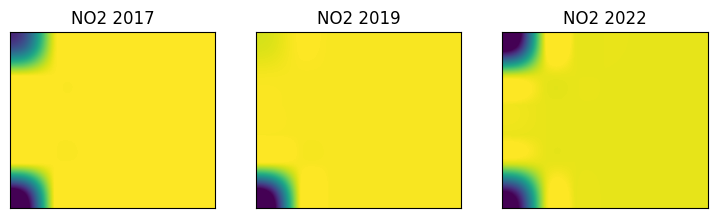

In [190]:
# Plot each location over time
fig, axs = plt.subplots(nrows=1, ncols=len(times), figsize=(9, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

for ax, time in zip(axs.flat, times):
    predictions = time_preds[str(time)]
    predictions = np.array(predictions)
    ax.imshow(predictions, cmap='viridis', interpolation='spline16')
    ax.set_title(f'{gas_to_train} {time[0]}')

plt.show()

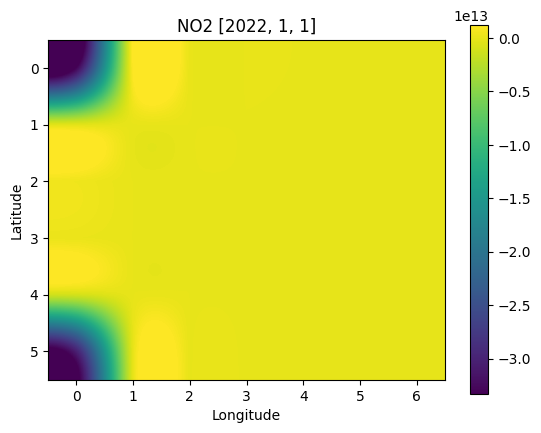

In [179]:
# Code to plot a location over specific time

# plt.imshow(predictions, cmap='viridis', interpolation='spline16')
# plt.title(f'{gas_to_train} {time}')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.colorbar()
# plt.show()

# Testing

In [191]:
# Test each model
X = df[['Latitude', 'Longitude', 'Year', 'Month', 'Day']]

mses = {}
maes = {}

# Test gas models with mse and mae
for gas in gases:
  y = df[gas].values

  # get yhat
  model = models[gas]
  yhat = model.predict(X)

  # score
  mae = mean_absolute_error(y, yhat)
  mse = mean_squared_error(y, yhat)

  mses[gas] = mse
  maes[gas] = mae
  print(f"{gas}: mae: {mae}, mse: {mse}")

avg_mse = sum(mses.values()) / len(mses)
avg_mae = sum(maes.values()) / len(maes)

# use cvs main model
cvs = cross_val_score(Model, X, y, cv=5, scoring="r2").mean()
print(f"CVS: {cvs}")
print(f"Average mse: {avg_mse}")
print(f"Average mae: {avg_mae}")


PM2.5: mae: 27.12577016018666, mse: 1667.519715644547
PM10: mae: 47.80384236403356, mse: 4394.852427335305
NO: mae: 16.597859975739475, mse: 717.0902989499293
NO2: mae: 11.907877200007981, mse: 345.8194761887231
NOx: mae: 19.353062023837413, mse: 906.9304378748986
NH3: mae: 9.337489648925189, mse: 244.1879137863645
SO2: mae: 3.0169838622640177, mse: 23.136294136871605
CO: mae: 0.38055116713904297, mse: 0.40640811687813605
Ozone: mae: 8.234876565714286, mse: 139.77867985110402
CVS: -0.31052091293024303
Average mse: 937.7468502094024
Average mae: 15.973145885316402
